In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Pick the start and goal location

In [2]:
%matplotlib tk
grid : np.ndarray = np.load('occupancy_grid.npy')
rows, cols = grid.shape

plt.figure(figsize=(15, 15))
plt.imshow(grid, cmap='gray')
start_coords = plt.ginput(1, show_clicks=False)[0]
plt.scatter(start_coords[0], start_coords[1], c = 'b')

goal_coords = plt.ginput(1, show_clicks=False)[0]
plt.scatter(goal_coords[0], goal_coords[1], c = 'r')

goal_loc = (int(goal_coords[1]), int(goal_coords[0]))
start_loc = (int(start_coords[1]), int(start_coords[0]))

plt.show()

In [3]:
class Node():
    def __init__(self, row:int, col:int):
        self.loc = (row, col)
        self.predecessor = None

    def __str__(self):
        return(f"loc : {self.loc}")


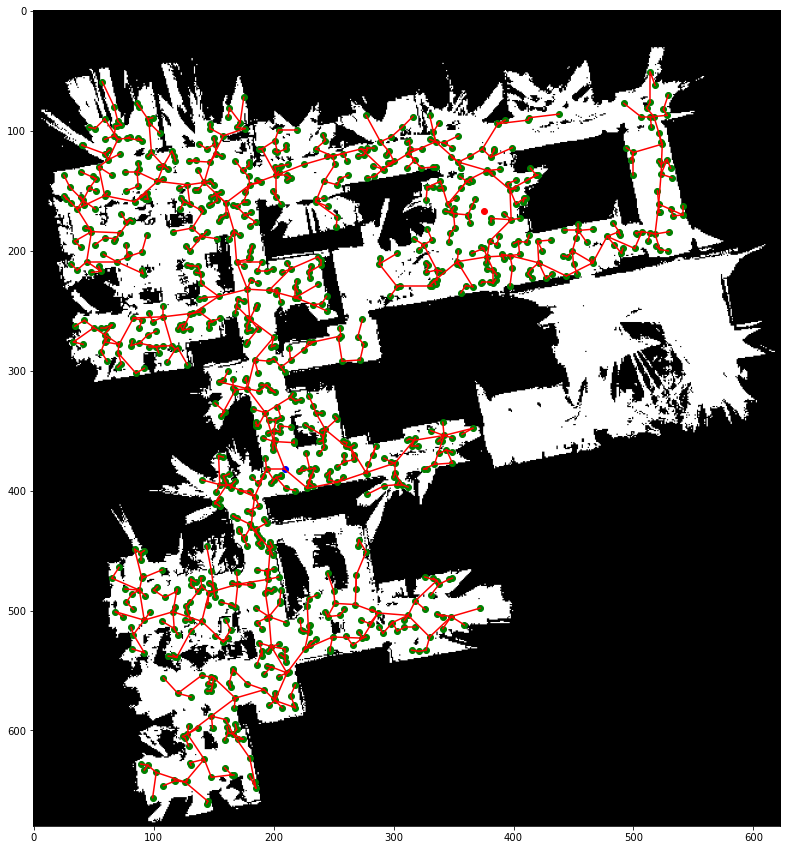

In [4]:
%matplotlib inline
class RRT():
    def __init__(self, grid:np.ndarray, start_loc:tuple[int, int], goal_loc:tuple[int, int]):
        self.grid = grid
        self.rows = grid.shape[0]
        self.cols = grid.shape[1]
        self.nodes = {}
        self.step_len = 25
        self.start_loc = start_loc
        self.goal_loc = goal_loc

        self.add_start_and_goal_node()

        self.fig = plt.figure(figsize=(15, 15))
        self.ax = self.fig.add_subplot(111)
        self.ax.imshow(grid, cmap="gray")
        self.ax.scatter(self.start_loc[1], self.start_loc[0], c='b')
        self.ax.scatter(self.goal_loc[1], self.goal_loc[0], c='r')



    def add_start_and_goal_node(self):
        self.nodes[start_loc] = Node(*start_loc)
        self.nodes[goal_loc]  = Node(*goal_loc)

    def distance(self, node_1:Node, node_2:Node):
        return np.linalg.norm([node_1.loc[0] - node_2.loc[0],
                               node_1.loc[1] - node_2.loc[1]])
    
    def sample_node(self):
        row = np.random.randint(rows)
        col = np.random.randint(cols)

        while not self.grid[row, col] or (row, col) in self.nodes.keys():
            row = np.random.randint(rows)
            col = np.random.randint(cols)

        return Node(row, col)
    
    def find_nearest_node(self, sampled_node:Node):
        least_dist = np.inf
        for node_loc in self.nodes:
            if node_loc == self.goal_loc:
                continue

            node = self.nodes[node_loc]
            dist = self.distance(node, sampled_node)
            if dist < least_dist:
                least_dist = dist
                nearest_node:Node = node

        return nearest_node

    def get_new_node(self, nearest_node:Node, sampled_node:Node):
        dist = self.distance(nearest_node, sampled_node)
        if dist <= self.step_len:
            new_node_loc = sampled_node.loc

        else:
            dir_vector = np.array([sampled_node.loc[0] - nearest_node.loc[0],
                                   sampled_node.loc[1] - nearest_node.loc[1]]).astype(np.float64)
            
            
            norm_dir = np.linalg.norm(dir_vector)
            scale = self.step_len/norm_dir

            
            dir_vector *= scale
            dir_vector_int = np.round(dir_vector).astype(np.int64)
            
            new_node_loc = (int(dir_vector_int[0] + nearest_node.loc[0]), int(dir_vector_int[1] + nearest_node.loc[1]))
        
        new_node = Node(new_node_loc[0], new_node_loc[1])
        new_node.predecessor = nearest_node

        return new_node

    def validate_new_node(self, new_node:Node, nearest_node:Node):
        y1, x1 = new_node.loc
        y2, x2 = nearest_node.loc
        # print(nearest_node.loc, new_node.loc)
        steps = max(abs(x2 - x1), abs(y2 - y1))
        # print(steps)
        for t in range(steps + 1):
            x = round(x1 + t * (x2 - x1) / steps)
            y = round(y1 + t * (y2 - y1) / steps)
            if not self.grid[y, x]:
                return False
            
        self.nodes[new_node.loc[0], new_node.loc[1]] = new_node
        return True
    
    def plot(self, sampled_node:Node, nearest_node:Node, new_node:Node):
        clear_output(wait=True)
        # self.ax.scatter(sampled_node.loc[1], sampled_node.loc[0], c='orange')
        self.ax.scatter(new_node.loc[1], new_node.loc[0], c='g')
        self.ax.plot([new_node.loc[1], nearest_node.loc[1]],
                     [new_node.loc[0], nearest_node.loc[0]], c = 'r')
        # plt.show()

    def search(self):
        for _ in range(1000):
            is_valid = False
            while not is_valid:
                
                sampled_node = self.sample_node()
                nearest_node = self.find_nearest_node(sampled_node)
                new_node = self.get_new_node(nearest_node, sampled_node)
                is_valid = self.validate_new_node(new_node, nearest_node)

            self.plot(sampled_node, nearest_node, new_node) 

            if self.distance(new_node, self.nodes[self.goal_loc]) < 3:
                self.nodes[self.goal_loc].predecessor = new_node
                print("PATH FOUND!")
                break

rrt = RRT(grid, start_loc, goal_loc)
rrt.search()